# Bi-LSTM Implementation

- Author: Ilias Chatzistefanidis
- Date: 23 September 2022

This notebook includes the implementation of the Bidirectional Long short-term Memory (Bi-LSTM) Neural Network method on the CQI data.

* Note that the logs of the notebook were produced with a non-subscription TPU runtime in Google Colab Notebook.

* We recommend uploading this notebook in Google Colab for easier execution. Nevertheless, the notebook can be executed locally after installing the appropriate libraries. 

* The data are fetched directly with a URL link from the github.

* Note that this is just a part of the work described in the publication. This notebook is designed to offer a foundation for further work to the researchers by providing the data and a part of the utilized ML pipeline.

**Table of Contents:**

>[Bi-LSTM Implementation](#scrollTo=Pt-__TQZFQtP)

>>[Include libraries](#scrollTo=nQpoWdBtQLej)

>>[Training Data](#scrollTo=kFXtS7ByiJ5l)

>>>[Data Pre-Processing](#scrollTo=vL8dGeTsMyUv)

>>>[Supervised Learning Structure](#scrollTo=_rsQqgzTS5qP)

>>[Bi-LSTM model](#scrollTo=iNl47Vn-W8J5)

>>[Validation Data](#scrollTo=DK4PmUnl5wRU)

>>>[Data Pre-processing](#scrollTo=3SNrUi_5YPFb)

>>>[Supervised Learning Structure](#scrollTo=1SRSBER1k0ZL)

>>>[Forecasting](#scrollTo=K_NXqwfilGk-)

>>>[Evaluation](#scrollTo=_MmABRV3mY25)

>>[Further Evaluation](#scrollTo=GKjR8rVPynii)

>>>[Time-series Cross Validation Technique](#scrollTo=YnHWQyh8z_Hg)

>>>[Forecasting Gathering](#scrollTo=TXO2bl5wJ3mU)

>>>[Model Evaluation (2-step)](#scrollTo=ChdpzO3xLYtk)



## Include libraries

* Note that the most packages are already installed in the Google Colab notebooks.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from random import random
from random import randint
from numpy import array
from numpy import zeros
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
import datetime
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.layers import RepeatVector
from keras.layers import Bidirectional
from keras.layers import GRU

from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

## Training Data

Read training data

In [2]:
url = 'https://raw.githubusercontent.com/ilias-chatzistefanidis/HetNets-steering/main/Data/train.csv'
df = pd.read_csv(url)
df

,0
0,10
1,9
2,14
3,14
4,14
...,...
181812,14
181813,14
181814,14
181815,14


Plot CQI data to observe the traffic patterns.

In [3]:
# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(y=list(df.values.reshape(-1))))

# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
        ),
        rangeslider=dict(
            visible=True
        )
    )
)

fig.show()

### Data Pre-Processing
Normalize data by rescaling them to the range [0,1] for efficient training.

In [4]:
# using the MinMaxScaler
values = np.array(df)
values = values.reshape((len(values), 1))

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)
print(normalized)

Min: 0.000000, Max: 15.000000
[[0.66666667]
 [0.6       ]
 [0.93333333]
 ...
 [0.93333333]
 [0.93333333]
 [0.93333333]]


### Supervised Learning Structure

![](https://raw.githubusercontent.com/ilias-chatzistefanidis/HetNets-steering/main/Figures/pre-processing.png)


We define a function to structure the data appropriately for a supervised learning problem. This function applies a filtering technique to reduce the data volume and then applies the sliding window technique to create a supervised learning structure.

The filtering algorithm reduces the dataset's size keeping, though, the patterns. In specific, we keep the mean of every $m$ indices creating a new series that is $m$ times smaller. After that, the sliding window method is applied forming a supervised learning structure. Precisely, we crop the filtered series into smaller sub-series ($X_i$) of fixed length, $L$. Each $X_i$ is the model's input and is shifted by one index to the future from the previous one ($X_{i-1}$). Further, each $X_i$ has a $y_i$ pair, which is the label (single value). Noticeably, each $y_i$ represents either only one CQI value or the mean of multiple ($p$) values. We prefer the latter option as it gives a clearer figure of the near future and is not affected by fluctuations. The values that are gathered for each $y_i$ are located after the respective $X_i$ in the dataset. This way, they represent the future of each $X_i$. 

The models' optimal $m$, $L$ and $p$ values are calculated after extensive experimentation. Generally, we need an input window that is large enough to capture the patterns and small enough to boost training. Hence, $m$, $L$ are configured so as to provide an efficient traffic picture. Moreover, $p$ should be large enough to smooth possible fluctuations and small enough to present an accurate figure of the near future.

An example for better understanding is the following (similar with the figure but extended).

Assume the normalized inputs:

$sequence = [0.93, 0.93, 0.80, 0.80, 0.67, 0.67, 0.60, 0.60, 0.50, 0.50, 0.40, 0.40]$

$L$ = 3

$p$ = 2

$m$ = 2

Then, after applying the filtering with $m = 2$, the filtered sequence is:

$filtered\_seq = [0.93, 0.80, 0.67, 0.60, 0.50, 0.40]$

Then, samples are created using the sliding window with $L = 3$, $p = 2$. 

$X_1 = [0.93, 0.80, 0.67]$
and $y_1 = 0.55$  (mean of $0.60$ and $0.50$).


Then, we slide by on value and

$X_2 = [0.80, 0.67, 0.60]$ and $y_2 = 0.45$ (mean of $0.50$ and $0.40$)

In [5]:
def split_sequence(sequence, n_steps, pred_steps, mean_batch):
    """
    This function applies a filtering technique to reduce the data volume and 
    then applies the sliding window technique to create a supervised learning structure.
    
    Regarding the filtering, the algorithm filters the sequence by calculating the average
    value of every m values. E.g. the average of every 5 values. In this way, the sequence's
    size is reduced maintaing the data patterns. 
    
    Regarding the sliding window, the algorithm calculates input windows X_i and the respective
    y_i labels to be fed into the model. Each input window is slided by one value to the future
    to create multiple samples for the model. Each X has length L. Each y is the label and 
    represent the forecasting of the model. Each y is a single value that represents the average 
    of multiple values. The number of these value that are used to calculate each y is p.
    Importantly, these values of the y label are locating after the respective X values to
    represent the future.

    Params:

    - sequence: input sequence
    - n_steps (L): input window time-steps/length   (length of X)
          The number of values that will be used to form the input window of the model
    - pred_steps (p): number of time-steps used for output/label(y)
          The number of values that will be used to calculate an average value (mean).
          This average value will be the y label. 
            e.g. if pred_steps equals 5, the mean of 5 values will be the y label
    - mean_batch (m): filtering window length
          The number of values that will be used by the filtering window

    An example for better understanding is the following:

    Assume the normalized inputs:
    sequence = [0.93, 0.93, 0.80, 0.80, 0.67, 0.67, 0.60, 0.60, 0.50, 0.50, 0.40, 0.40]
    n_steps = 3
    pred_steps = 2
    mean_batch = 2

    Then the filtered sequence after applying the filtering with mean_batch = 2 is:
    filtered_seq = [0.93, 0.80, 0.67, 0.60, 0.50, 0.40]

    Then samples are created using the sliding window with n_steps = 3, pred_steps = 2. 

    X_1 = [0.93, 0.80, 0.67]
    and y_1 = the average of 0.60 and 0.50.
    Hence, y_1 = [0.55]

    Then, we slide by on value and
    X_2 = [0.80, 0.67, 0.60] and y_2 = [0.45] (mean of 0.50 and 0.40)
    """
    new_sequence = []

    ### Filtering
    temp_sum = 0
    # iterate through sequence
    for i,item in enumerate(sequence,start=1):
        temp_sum+=item
        # for every m values calculate the mean value and 
        # append it in the new sequence
        if i%mean_batch == 0:
            mean_temp = temp_sum/mean_batch
            temp_sum=0
            new_sequence.append(mean_temp)

    # work with the new filtered sequence
    sequence = new_sequence

    # adjust the params to the new sequence
    n_steps = int(n_steps/mean_batch)
    pred_steps = int(pred_steps/mean_batch)

    ### Sliding window technique
    X, y = list(), list()
    # iterate through sequence
    for i in range(len(sequence)):
        # for each iteration (i),
        # find the end of this pattern (X_i)
        end_ix = i + n_steps
        
        # check if X_i is beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # check if values for y_i go beyond the sequence
        pred_ix = end_ix + pred_steps
        if pred_ix > len(sequence)-1:
            break
            
        # compute the y label (mean of p values after X_i)
        mean_pred = np.mean(sequence[end_ix:pred_ix])
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], mean_pred

        # store sample
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

Now that we defined the function, lets use it on our normalized data

In [6]:
# define input sequence
raw_seq = normalized
# choose a number of input time steps
n_steps = 400
# choose a number of prediction steps to calculate each label
pred_steps = 70
# choose filtering window 
mean_batch = 5


# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps, pred_steps, mean_batch)

Print X, y shapes

In [7]:
print(X_train.shape)
print(y_train.shape)

(36269, 80, 1)
(36269,)


We can see that we have 36269 samples. Each sample has a X with shape [80,1], which is the model's input and also has a y label.

Now, reshape samples appropriately for the model

In [8]:
n_features = 1
X_train = X_train.reshape((   X_train.shape[0],  X_train.shape[1],  1   ))

In [9]:
print(X_train.shape)
print(y_train.shape)

(36269, 80, 1)
(36269,)


## Bi-LSTM model

In this notebook we use the Bi-LSTM model

In [10]:
# define model
model = keras.Sequential()
model.add(Bidirectional(LSTM(25, activation='relu',return_sequences=True), input_shape=(int(n_steps/mean_batch), n_features)    ))
model.add(Bidirectional(LSTM(25, activation='relu') ))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 80, 50)           5400      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50)               15200     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0
_________________________________________________________________


In [11]:
# train model and calculate training time
a = datetime.datetime.now()
model.fit(X_train, y_train,  epochs=15, verbose=1, batch_size=2**6)
b = datetime.datetime.now()
diff = b-a
diff_secs = diff.total_seconds()
print("Training Time:", round(diff_secs,1),"seconds.")

Epoch 1/15
567/567 [==============================] - 73s 115ms/step - loss: 0.0225
Epoch 2/15
567/567 [==============================] - 67s 118ms/step - loss: 0.0103
Epoch 3/15
567/567 [==============================] - 65s 115ms/step - loss: 0.0081
Epoch 4/15
567/567 [==============================] - 65s 114ms/step - loss: 0.0065
Epoch 5/15
567/567 [==============================] - 65s 115ms/step - loss: 0.0051
Epoch 6/15
567/567 [==============================] - 65s 115ms/step - loss: 0.0040
Epoch 7/15
567/567 [==============================] - 65s 115ms/step - loss: 0.0031
Epoch 8/15
567/567 [==============================] - 65s 115ms/step - loss: 0.0026
Epoch 9/15
567/567 [==============================] - 65s 115ms/step - loss: 0.0023
Epoch 10/15
567/567 [==============================] - 65s 115ms/step - loss: 0.0019
Epoch 11/15
567/567 [==============================] - 65s 115ms/step - loss: 0.0018
Epoch 12/15
567/567 [==============================] - 65s 115ms/step - lo

## Validation Data

Now we use unseen CQI data (excluded from training set) to validate model. 

Read data

In [12]:
url = "https://raw.githubusercontent.com/ilias-chatzistefanidis/HetNets-steering/main/Data/test.txt"

val_df = pd.read_csv(url)
val_df

,14
0,5
1,6
2,6
3,12
4,12
...,...
2582,6
2583,6
2584,6
2585,6


Plot CQI data to observe the traffic patterns.

In [13]:
# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(y=list(val_df.values.reshape(-1))))

# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
        ),
        rangeslider=dict(
            visible=True
        )
    )
)

fig.show()

### Data Pre-processing

Follow the same pre-processing with the training data.

In [14]:
# prepare data for normalization
values = np.array(val_df)
values = values.reshape((len(values), 1))

# train the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

# normalize the dataset and print the first 5 rows
normalized_test = scaler.transform(values)
print(normalized_test)

Min: 0.000000, Max: 14.000000
[[0.35714286]
 [0.42857143]
 [0.42857143]
 ...
 [0.42857143]
 [0.42857143]
 [0.42857143]]


### Supervised Learning Structure

Use the function developed above to structure appropriately the validation data.

In [15]:
# define input sequence
raw_seq = normalized_test
# choose a number of time steps
n_steps = 400
# choose a number of prediction steps
pred_steps = 70
# mean_batch 
mean_batch = 5


# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps, pred_steps, mean_batch)

In [16]:
print(X_test.shape)
print(y_test.shape)

(423, 80, 1)
(423,)


### Forecasting

Use the pre-trained model to make forecasting on the validation data.

In [17]:
# init 2 sets for predictions and real values (labels)
all_preds_test = []
all_real_test = []

# iterate through the validation samples
for i in range(X_test.shape[0]):
    # print progress
    if i%100==0:
        print(i,'/',X_test.shape[0])
    
    # define model's input window
    x_input = X_test[i]

    # reshape appropriately
    x_input = x_input.reshape((1, int(n_steps/mean_batch), n_features))

    # predict
    yhat = model.predict(x_input, verbose=0)

    # inverse transform of the normalized scale back to the original scale of
    # CQI data [0,15]    
    y_pred = yhat
    y_real = y_test[i]
    y_pred_inversed = scaler.inverse_transform(y_pred)
    y_real_inversed = scaler.inverse_transform(np.array(y_real).reshape(-1,1))

    # store predictions and real values (labels)
    all_preds_test.append(y_pred_inversed)
    all_real_test.append(y_real_inversed)

0 / 423
100 / 423
200 / 423
300 / 423
400 / 423


### Evaluation

Plot the CQI forecasting compared with the real values.

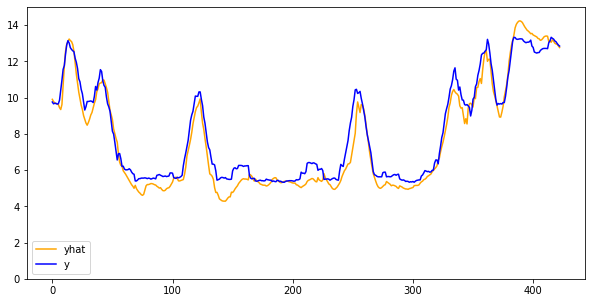

In [18]:
# reshape appropriately
all_preds_test = np.array(all_preds_test).reshape(-1)
all_real_test = np.array(all_real_test).reshape(-1)

# plot
plt.figure(figsize=[10,5])
plt.plot(all_preds_test,'orange',label="yhat")
plt.plot(all_real_test,'blue',label="y")
plt.ylim([0,15])
plt.legend()

Calculate Mean Absolute Error (MAE) between the forecasting and the real values.

In [19]:
print("MAE:", round(mean_absolute_error(all_preds_test, all_real_test),2))

MAE: 0.54


Calculate Mean Squared Error (MSE) between the forecasting and the real values.

In [20]:
print("MSE:", round(mean_squared_error(all_preds_test, all_real_test),2))

MSE: 0.45


## Further Evaluation

For further evaluation, we provide several more functions on the time-series cross validation technique.

### Time-series Cross Validation Technique

![](https://raw.githubusercontent.com/ilias-chatzistefanidis/HetNets-steering/main/Figures/time-series-cv.png)

Time-Series Cross Validation, a method similar to K-fold, is used to evaluate the model's accuracy. The pre-processed data are split into several folds of equal size. There are two sets; the training and the test set. Initially, we insert several serial folds to the training set following the timeline. At each iteration ($i$), the model is trained on the training set and is evaluated on the validation set calculating the error on unseen data. In every iteration, the training set is extended by one fold and the next one is used for a new validation. In the end, we calculate the mean of all validations as the final error. 

In [21]:
import math

def cross_validation_from_scratch(X, y, init_window=0, prediction_window=500):
    """
    This function applies the Time-series Cross Validation tecnique to efficiently 
    evaluate a model's predictive performance on multiple unseen data.

    Params:
    - X: Input X with samples
    - y: Input y with samples' labels
    - init_window: The initial offset of the training set
          This variable determines how many samples will be inserted in the training set
          before the beginning of the execution.
    - prediction_window: Number of samples on prediction/ length of folds
    """
    # init training sets
    X_splits = []
    y_splits = []

    # init validation sets
    X_pred_splits = []
    y_pred_splits = []

    # find the size of the data we need to split into folds
    # we split only the data after the initial offset
    size_to_split = X.shape[0] - init_window

    # determine num of splits/ number of folds
    n_splits = math.ceil(size_to_split/prediction_window)

    # iterate in each fold
    for i in range(n_splits):
        # compute X,y

        # X of training set
        X_split = X[: init_window + i * prediction_window ]
        # X of validation set
        X_pred_split = X[ init_window + i*prediction_window : init_window + (i+1)*prediction_window ]

        # y of training set
        y_split = y[: init_window + i * prediction_window ]
        # y of validation set
        y_pred_split = y[ init_window + i*prediction_window : init_window + (i+1)*prediction_window ]

        # store them
        X_splits.append(X_split)
        y_splits.append(y_split)

        X_pred_splits.append(X_pred_split)
        y_pred_splits.append(y_pred_split)

    # test that everything is ok
    if  len(X_splits) == len(y_splits) == len(X_pred_splits) == len(y_pred_splits):
        print("[INFO]: Num of Folds:",len(X_splits))
    else:
        print('[ERROR]: Error occured!')
        return

    return X_splits, y_splits, X_pred_splits, y_pred_splits

### Forecasting Gathering
Make a function with the forecasting step that we used before.

In [22]:
# function to predict
def collect_predictions(model, X_test, y_test, verbose=0):
    """
    This function utilizes the pretrained model and collects the predictions on 
    the desired test set.

    Params:
    - model: the variable of the pre-trained model
    - X_test: the X samples of the test set
    - y_test: the y labels of the X samples
    - verbose: the verbose parameter to be used by the predict() function of the model
    """
    # init 2 sets for predictions and real values (labels)
    all_preds_test = []
    all_real_test = []

    # iterate through the validation samples
    for i in range(X_test.shape[0]):
        # define model's input window
        x_input = X_test[i]

        # reshape appropriately
        x_input = x_input.reshape((1, int(n_steps/mean_batch), n_features))

        # predict
        yhat = model.predict(x_input, verbose=0)

        # inverse transform of the normalized scale back to the original scale of
        # CQI data [0,15]    
        y_pred = yhat
        y_real = y_test[i]
        y_pred_inversed = scaler.inverse_transform(y_pred)
        y_real_inversed = scaler.inverse_transform(np.array(y_real).reshape(-1,1))

        # store predictions and real values (labels)
        all_preds_test.append(y_pred_inversed)
        all_real_test.append(y_real_inversed)
    return all_preds_test,all_real_test

### Model Evaluation (2-step)

Develop a function that utilizes the aforementioned functions to evaluate the model using two steps.

* Step 1: Apply the Time-Series Cross Validation technique to the dataset

* Step 2: Train on the complete dataset and validate on the experimental data (validation.csv)

In [23]:
from sklearn.metrics import mean_squared_error
import datetime

def validate_model(epochs, X_train, y_train, X_test, y_test,init_w=40500,pred_w=500):
  """
  This function utilizes two more funtions:
    - cross_validation_from_scratch()
    - collect_predictions()
  It is designed to evaluate the model using two steps:
    1) Apply the Time-Series Cross Validation technique to the dataset
    2) Train on the complete dataset and validate on the experimental data

  Params:

  - epochs: The epochs to train the model
  - X_train, y_train: The samples to be used in the first step.
  - X_test, y_test: The samples to be used in the seconds step.
  - init_w: The offset of the time-series cross validation technique.
  - pred_w: The length of the folds in the time-series cross validation technique.
  """
  # Create Folds
  print("[INFO]: Split Dataset for Time-series CV")
  X_splits, y_splits, X_pred_splits, y_pred_splits = cross_validation_from_scratch(X_train,y_train,init_window=init_w, prediction_window=pred_w)

  # init lists for metrics 
  MAE_hist = []
  RMSE_hist = []
  time_in_folds = []

  # counter of for loop
  counter=0   

  # utilize the folds to apply time-series cross validation
  print("[INFO]: Begin Time-series CV")
  for X_temp, y_temp, X_pred_temp, y_pred_temp in zip(X_splits, y_splits, X_pred_splits, y_pred_splits):
    counter+=1
    print("[INFO]: Fold ",counter)

    # define model
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(25, activation='relu',return_sequences=True), input_shape=(int(n_steps/mean_batch), n_features)    ))
    model.add(Bidirectional(LSTM(25, activation='relu') ))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # start counting training time
    a = datetime.datetime.now()

    # fit model
    print("[INFO]: Train Model on Training Set")
    model.fit(X_temp, y_temp, epochs=epochs, verbose=1, batch_size=2**6)

    # calculate training time
    b = datetime.datetime.now()
    diff = b-a
    diff_secs = diff.total_seconds()

    # store training time
    time_in_folds.append(diff_secs)

    # make predictions 
    print("[INFO]: Collect Predictions on Validation Set",counter)
    all_preds_test,all_real_test = collect_predictions(model, X_pred_temp, y_pred_temp)

    # reshape for evaluation
    all_preds_test = np.array(all_preds_test).reshape(-1)
    all_real_test = np.array(all_real_test).reshape(-1)

    # evaluate
    MAE_current = mean_absolute_error(all_preds_test, all_real_test)
    RMSE_current = mean_squared_error(all_preds_test, all_real_test)

    # save stats
    MAE_hist.append(MAE_current)
    RMSE_hist.append(RMSE_current)

    print("[RESULTS]: ",counter,"/",len(X_splits)," Time:",round(diff_secs,1), "MAE_current:",round(MAE_current,2), "RMSE_current",round(RMSE_current,2)) 
    print()

  print("[INFO]: End of Time-Series CV")
  print("[INFO]: Train on whole training set and evaluate on experimental real data (excluded from training set)")
  
  # define model
  model = keras.Sequential()
  model.add(Bidirectional(LSTM(25, activation='relu',return_sequences=True), input_shape=(int(n_steps/mean_batch), n_features)    ))
  model.add(Bidirectional(LSTM(25, activation='relu') ))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  # start counting training time
  a = datetime.datetime.now()

  # fit model
  print("[INFO]: Train Model on the whole training dataset")
  model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=2**6)

  # calculate training time
  b = datetime.datetime.now()
  diff = b-a
  diff_secs = diff.total_seconds()

  # make predictions
  print("[INFO]: Collect Predictions on experimental data")
  all_preds_test,all_real_test = collect_predictions(model, X_test, y_test)

  # reshape for evaluation
  all_preds_test = np.array(all_preds_test).reshape(-1)
  all_real_test = np.array(all_real_test).reshape(-1)

  # plot forecasting vs actual values
  print("[INFO]: Plot the forecasting on experimental data:")
  plt.figure(figsize=[10,5])
  plt.plot(all_preds_test,'orange',label="yhat")
  plt.plot(all_real_test,'blue',label="y")
  plt.ylim([0,15])
  plt.legend()
  plt.show()

  # evaluate with MAE and RMSE metrics
  MAE_real_data = mean_absolute_error(all_preds_test, all_real_test)
  RMSE_real_data = mean_squared_error(all_preds_test, all_real_test)

  # print results
  print("[RESULTS]: Overall Fold MAE:   ",round(np.mean(MAE_hist),2),'(mean)  ',round(np.median(MAE_hist),2),'(median)' )
  print("[RESULTS]: Overall Fold RMSE:  ",round(np.mean(RMSE_hist),2),'(mean)  ',round(np.median(RMSE_hist),2),'(median)'  )
  print("[RESULTS]: Mean Time in Folds:",round(np.mean(time_in_folds) ,2))
  print("[RESULTS]: Tesing MAE (real data): ",round(MAE_real_data,2))
  print("[RESULTS]: Tesing RMSE (real data):",round(RMSE_real_data,2))
  print("[RESULTS]: Time in real data:",round(diff_secs,2))

  return MAE_hist, RMSE_hist, MAE_real_data, RMSE_real_data

Before use the last function to validate the model, we print the shape of training data in order to decide about the splitting of time-series cross validation.

In [24]:
print(X_train.shape)

(36269, 80, 1)


We have 36269 samples. So, to save time, we provide an example with 2 Folds and 500 samples in each one. To achieve that we will provide:

- $init\_w = 35269$
- $pred\_w = 500$

Thus, the splitting of the dataset into 2 Fold will take place after the $init\_w$:

$splitting = all\_samples - init\_w = 36269 - 35269 = 1000$

These 1000 samples will be splitted into two folds.

* Note that it is not mandatory to make all these calculation since the algorithm will make the splitting even if the division has a non zero remainder. In that case, the last fold will be smaller than the $pred\_w.$

[INFO]: Split Dataset for Time-series CV
[INFO]: Num of Folds: 2
[INFO]: Begin Time-series CV
[INFO]: Fold  1
[INFO]: Train Model on Training Set
Epoch 1/10
552/552 [==============================] - 85s 129ms/step - loss: 0.0231
Epoch 2/10
552/552 [==============================] - 73s 132ms/step - loss: 0.0120
Epoch 3/10
552/552 [==============================] - 69s 125ms/step - loss: 0.0066
Epoch 4/10
552/552 [==============================] - 69s 124ms/step - loss: 0.0053
Epoch 5/10
552/552 [==============================] - 69s 126ms/step - loss: 0.0044
Epoch 6/10
552/552 [==============================] - 68s 123ms/step - loss: 0.0059
Epoch 7/10
552/552 [==============================] - 68s 123ms/step - loss: 0.0050
Epoch 8/10
552/552 [==============================] - 66s 119ms/step - loss: 0.0032
Epoch 9/10
552/552 [==============================] - 69s 124ms/step - loss: 0.0025
Epoch 10/10
552/552 [==============================] - 69s 125ms/step - loss: 0.0022
[INFO]: Colle

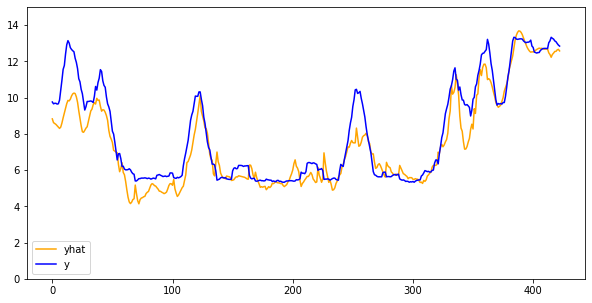

[RESULTS]: Overall Fold MAE:    0.6 (mean)   0.6 (median)
[RESULTS]: Overall Fold RMSE:   0.71 (mean)   0.71 (median)
[RESULTS]: Mean Time in Folds: 752.03
[RESULTS]: Tesing MAE (real data):  0.74
[RESULTS]: Tesing RMSE (real data): 1.01
[RESULTS]: Time in real data: 713.33


In [29]:
MAE_hist, RMSE_hist, MAE_real_data, RMSE_real_data = validate_model(10, X_train, y_train, X_test, y_test, init_w=35269,pred_w=500)

Lets review the results for better understanding.

In [30]:
MAE_hist

[0.394443749224345, 0.8118566734441124]

In [31]:
RMSE_hist

[0.29031756569560413, 1.1242846112923002]

Here, we see that the MAE and RMSE are better in the first Fold being 0.4 and 0.3 respectively. In the second Fold there are 0.81 and 1.12 respectively.

Let's analyze the experimental data now.

In [32]:
MAE_real_data

0.7416802128357328

In [33]:
RMSE_real_data

1.0149360008785842

Here, we can see moderate performance with MAE and RMSE being 0.74 and 1.01 accordingly.

Overall, the results in folds show that:

- Overall Mean Fold MAE = 0.6
- Overall Fold RMSE = 0.71
- Mean Time in Folds = 752.03 seconds (12.5 minutes)

The results on experimental data are:

- MAE:  0.74
- RMSE: 1.01
- Training Time: 713.33 seconds (12 mins) 
